# Deforestation Model (Landsat SR + QA_PIXEL)

This notebook implements a **stronger unlabeled (no ground-truth) deforestation workflow** using only Landsat Collection 2 L2 Surface Reflectance files:

- Uses **QA_PIXEL** to mask clouds/shadows/snow (critical for stable time series)
- Builds **yearly cloud-masked composites** (median NDVI/NDMI per year)
- Detects deforestation as **persistent vegetation/moisture loss** relative to a baseline forest state

Outputs (saved under `out_dir`):

- Baseline composites + baseline forest mask
- `deforestation_year.tif` (0 = no loss; else year of first persistent loss)
- `deforestation_mask.tif` (1 = loss)
- `Deforestation_Yearly_Stats.csv` + plots + `run_manifest.json`


In [1]:
# 1) Environment & Reproducibility
from __future__ import annotations

import json
import platform
import sys
from dataclasses import asdict, dataclass
from datetime import datetime
from pathlib import Path

import numpy as np

# Reproducibility
SEED = 42
np.random.seed(SEED)

print("Run started:", datetime.now().isoformat(timespec="seconds"))
print("Python:", sys.version)
print("Platform:", platform.platform())

# Optional: print versions (won't crash if missing)
def _try_version(mod_name: str) -> str:
    try:
        mod = __import__(mod_name)
        return getattr(mod, "__version__", "unknown")
    except Exception:
        return "(not installed)"

for m in ["numpy", "pandas", "geopandas", "rasterio", "matplotlib"]:
    print(f"{m}:", _try_version(m))

# ---- Paths (portable defaults) ----
def find_project_root(start: Path) -> Path:
    """Walk upward until we find a folder that looks like this repo."""
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Landsat_By_Year").exists() and (p / "AOI").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
landsat_root = PROJECT_ROOT / "Landsat_By_Year"

# Choose which district to run
RUN_DISTRICT = "NuwaraEliya"  # "Kandy" or "NuwaraEliya"

_DISTRICTS = {
    "Kandy": {
        "aoi": "kandy_District_AOI.geojson",
        "out_dir": "Kandy",
    },
    "NuwaraEliya": {
        "aoi": "nuwara_eliya_District_AOI.geojson",
        "out_dir": "NuwaraEliya",
    },
}

if RUN_DISTRICT not in _DISTRICTS:
    raise ValueError(f"Unknown RUN_DISTRICT={RUN_DISTRICT!r}. Choose one of: {list(_DISTRICTS)}")

aoi_path = PROJECT_ROOT / "AOI" / _DISTRICTS[RUN_DISTRICT]["aoi"]
out_dir = PROJECT_ROOT / _DISTRICTS[RUN_DISTRICT]["out_dir"]
out_dir.mkdir(parents=True, exist_ok=True)

config = {
    "seed": SEED,
    "project_root": str(PROJECT_ROOT),
    "landsat_root": str(landsat_root),
    "aoi_path": str(aoi_path),
    "out_dir": str(out_dir),
    "baseline_years": [2013, 2014, 2015],
    "analysis_years": list(range(2016, 2026)),
    "forest_ndvi_threshold": 0.55,
    "ndvi_drop_threshold": 0.20,
    "ndmi_drop_threshold": 0.10,
    "min_persistence_years": 2,
    # Quality gate: minimum clear observations contributing to a yearly composite pixel
    "min_valid_obs_per_year": 4 if RUN_DISTRICT == "NuwaraEliya" else 3,
}

print("\nConfig:")
print(json.dumps(config, indent=2))

(out_dir / "run_config.json").write_text(json.dumps(config, indent=2), encoding="utf-8")
print("Saved:", out_dir / "run_config.json")


Run started: 2025-12-27T17:42:52
Python: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0
numpy: 1.26.4
pandas: 2.1.4
geopandas: 1.1.1
rasterio: 1.4.3
matplotlib: 3.10.6

Config:
{
  "seed": 42,
  "project_root": "C:\\Users\\User\\Desktop\\Deforestation\\Deforestation",
  "landsat_root": "C:\\Users\\User\\Desktop\\Deforestation\\Deforestation\\Landsat_By_Year",
  "aoi_path": "C:\\Users\\User\\Desktop\\Deforestation\\Deforestation\\AOI\\nuwara_eliya_District_AOI.geojson",
  "out_dir": "C:\\Users\\User\\Desktop\\Deforestation\\Deforestation\\NuwaraEliya",
  "baseline_years": [
    2013,
    2014,
    2015
  ],
  "analysis_years": [
    2016,
    2017,
    2018,
    2019,
    2020,
    2021,
    2022,
    2023,
    2024,
    2025
  ],
  "forest_ndvi_threshold": 0.55,
  "ndvi_drop_threshold": 0.2,
  "ndmi_drop_threshold": 0.1,
  "min_persistence_years": 2,
  "min_valid_obs_per_year": 4
}
Saved: C:\Users\User

In [2]:
# 2) Ingest Scenes (recursive scan, integrity checks, metadata)
import re

import geopandas as gpd
import rasterio
from rasterio.errors import RasterioIOError

BANDS_REQUIRED = {
    "red": "SR_B4.TIF",
    "nir": "SR_B5.TIF",
    "swir1": "SR_B6.TIF",
    "qa_pixel": "QA_PIXEL.TIF",
}

DATE_RE = re.compile(r"_(\d{8})_")

def parse_date_from_name(filename: str):
    m = DATE_RE.search(filename)
    if not m:
        return None
    s = m.group(1)
    try:
        return datetime(int(s[:4]), int(s[4:6]), int(s[6:8]))
    except ValueError:
        return None

# Scene anchor = SR_B4
red_files = list(landsat_root.rglob(f"*_{BANDS_REQUIRED['red']}"))
print("Found SR_B4 anchors:", len(red_files))

rows = []
skipped = []  # list of dicts

for rf in red_files:
    dt = parse_date_from_name(rf.name)
    if dt is None:
        continue
    scene_id = rf.name[: -len(f"_{BANDS_REQUIRED['red']}")]

    files = {}
    ok = True
    reason = ""
    for k, suf in BANDS_REQUIRED.items():
        p = rf.parent / f"{scene_id}_{suf}"
        if not p.exists():
            ok = False
            reason = f"missing {suf}"
            break
        try:
            if p.stat().st_size == 0:
                ok = False
                reason = f"zero-byte {p.name}"
                break
        except OSError:
            ok = False
            reason = f"stat failed {p.name}"
            break
        files[k] = p

    if not ok:
        skipped.append({"scene_id": scene_id, "date": dt.isoformat()[:10], "reason": reason, "folder": str(rf.parent)})
        continue

    rows.append(
        {
            "scene_id": scene_id,
            "date": dt,
            "year": dt.year,
            "folder": str(rf.parent),
            **{f"file_{k}": str(v) for k, v in files.items()},
        }
    )

import pandas as pd

df_scenes = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
df_skipped = pd.DataFrame(skipped).sort_values(["date", "scene_id"]) if skipped else pd.DataFrame(columns=["scene_id", "date", "reason", "folder"])

print("Usable scenes:", len(df_scenes))
print("Skipped scenes:", len(df_skipped))

(df_scenes).to_csv(out_dir / "scenes_index.csv", index=False)
(df_skipped).to_csv(out_dir / "skipped_scenes.csv", index=False)
print("Saved:", out_dir / "scenes_index.csv")
print("Saved:", out_dir / "skipped_scenes.csv")

print("\nScenes per year (usable):")
print(df_scenes.groupby("year").size())

print("\nTop skip reasons:")
if len(df_skipped):
    print(df_skipped["reason"].value_counts().head(10))
else:
    print("(none)")


Found SR_B4 anchors: 247
Usable scenes: 211
Skipped scenes: 36
Saved: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\scenes_index.csv
Saved: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\skipped_scenes.csv

Scenes per year (usable):
year
2013    11
2014    14
2015    14
2016    17
2017    16
2018    15
2019    15
2020    14
2021    18
2022    17
2023    21
2024    22
2025    17
dtype: int64

Top skip reasons:
reason
zero-byte LC08_L2SP_141055_20140206_20200912_02_T1_SR_B4.TIF    1
zero-byte LC08_L2SP_141055_20211108_20211117_02_T2_SR_B6.TIF    1
zero-byte LC09_L2SP_141055_20240430_20240502_02_T1_SR_B4.TIF    1
zero-byte LC09_L2SP_141055_20240719_20240720_02_T1_SR_B4.TIF    1
zero-byte LC09_L2SP_141055_20240804_20240805_02_T1_SR_B4.TIF    1
zero-byte LC09_L2SP_141055_20240905_20240906_02_T1_SR_B4.TIF    1
zero-byte LC09_L2SP_141055_20240921_20240924_02_T1_SR_B4.TIF    1
zero-byte LC09_L2SP_141055_20250212_20250213_02_T1_SR_B4.TIF    1
zero-byte LC08_L2SP_1

In [3]:
# 3) Helpers: QA mask, scaling, clip + align to a reference grid
from typing import Optional

import rasterio
from rasterio.mask import mask
from rasterio.warp import Resampling, reproject

aoi = gpd.read_file(aoi_path)
if len(aoi) == 0:
    raise ValueError(f"AOI is empty: {aoi_path}")

# Cache AOI reprojections by CRS to avoid repeating expensive conversions
_aoi_by_crs: dict[str, object] = {}

def _aoi_in_crs(crs) -> object:
    key = str(crs)
    if key not in _aoi_by_crs:
        _aoi_by_crs[key] = aoi.to_crs(crs)
    return _aoi_by_crs[key]

def qa_pixel_is_clear(qa: np.ndarray) -> np.ndarray:
    """True where pixel is usable (not fill/cloud/shadow/cirrus/snow)."""

    def bit_is_set(arr: np.ndarray, bit: int) -> np.ndarray:
        return (arr.astype(np.uint16) & (1 << bit)) != 0

    bad = (
        bit_is_set(qa, 0)  # fill
        | bit_is_set(qa, 1)  # dilated cloud
        | bit_is_set(qa, 2)  # cirrus
        | bit_is_set(qa, 3)  # cloud
        | bit_is_set(qa, 4)  # cloud shadow
        | bit_is_set(qa, 5)  # snow
    )
    return ~bad

def sr_scale(arr: np.ndarray) -> np.ndarray:
    # Landsat C2 L2 SR scaling
    return arr.astype(np.float32) * 0.0000275 - 0.2

def calc_ndvi(red: np.ndarray, nir: np.ndarray) -> np.ndarray:
    return (nir - red) / (nir + red + 1e-10)

def calc_ndmi(nir: np.ndarray, swir1: np.ndarray) -> np.ndarray:
    return (nir - swir1) / (nir + swir1 + 1e-10)

def read_clip(path: Path) -> tuple[np.ndarray, dict]:
    """Read a single-band raster and clip to AOI. Returns (array, meta)."""
    with rasterio.open(path) as src:
        aoi_reproj = _aoi_in_crs(src.crs)
        out_img, out_transform = mask(src, aoi_reproj.geometry, crop=True)
        meta = src.meta.copy()
        meta.update(
            {
                "height": out_img.shape[1],
                "width": out_img.shape[2],
                "transform": out_transform,
            }
        )
        return out_img[0], meta

def align_to_ref(
    arr: np.ndarray,
    src_meta: dict,
    ref_meta: dict,
    dst_dtype=np.float32,
    *,
    fill_value=None,
) -> np.ndarray:
    """Reproject/align a clipped array onto the reference grid."""
    if fill_value is None:
        fill_value = np.nan if np.issubdtype(np.dtype(dst_dtype), np.floating) else 0
    dst = np.full((ref_meta["height"], ref_meta["width"]), fill_value, dtype=dst_dtype)

    reproject(
        source=arr,
        destination=dst,
        src_transform=src_meta["transform"],
        src_crs=src_meta["crs"],
        dst_transform=ref_meta["transform"],
        dst_crs=ref_meta["crs"],
        resampling=Resampling.nearest,
        src_nodata=src_meta.get("nodata", None),
        dst_nodata=fill_value if (fill_value is not None and not (isinstance(fill_value, float) and np.isnan(fill_value))) else None,
    )
    return dst

def write_geotiff(path: Path, arr: np.ndarray, ref_meta: dict, dtype: str, nodata) -> None:
    # Many GIS tools handle NaN nodata poorly. If float + nodata is NaN, write a numeric nodata instead.
    arr_to_write = arr
    nodata_to_write = nodata
    if dtype in {"float32", "float64"} and isinstance(nodata, float) and np.isnan(nodata):
        nodata_to_write = -9999.0
        arr_to_write = np.where(np.isfinite(arr), arr, nodata_to_write).astype(np.float32 if dtype == "float32" else np.float64)

    meta = ref_meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "count": 1,
            "dtype": dtype,
            "nodata": nodata_to_write,
            "compress": "LZW",
        }
    )

    path.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(arr_to_write, 1)

# Pick a reference grid from the first readable scene
ref_meta = None
ref_scene = None

for _, r in df_scenes.iterrows():
    try:
        _arr, _meta = read_clip(Path(r["file_red"]))
        ref_meta = _meta
        ref_scene = r["scene_id"]
        break
    except Exception:
        continue

if ref_meta is None:
    raise RuntimeError("Could not establish a reference grid from the available scenes.")

print("Reference grid from scene:", ref_scene)
print("CRS:", ref_meta["crs"], "size:", (ref_meta["height"], ref_meta["width"]))


Reference grid from scene: LC08_L2SP_141055_20130526_20200913_02_T1
CRS: PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] size: (1927, 1968)


In [4]:
# 4) Yearly composites (median NDVI/NDMI per year)

def composite_year(year: int) -> dict[str, object]:
    """Return dict with ndvi, ndmi composites + valid-count + provenance."""
    sub = df_scenes[df_scenes["year"] == year]
    if len(sub) == 0:
        return {"year": year, "ndvi": None, "ndmi": None, "valid_count": None, "used_scenes": []}

    ndvi_stack: list[np.ndarray] = []
    ndmi_stack: list[np.ndarray] = []
    used_scenes: list[str] = []
    skipped_local: list[dict] = []

    for _, r in sub.iterrows():
        scene_id = r["scene_id"]
        try:
            red_raw, red_meta = read_clip(Path(r["file_red"]))
            nir_raw, nir_meta = read_clip(Path(r["file_nir"]))
            swir_raw, swir_meta = read_clip(Path(r["file_swir1"]))
            qa_raw, qa_meta = read_clip(Path(r["file_qa_pixel"]))

            # Scale reflectance
            red = sr_scale(red_raw)
            nir = sr_scale(nir_raw)
            swir = sr_scale(swir_raw)

            # Compute indices on their native clipped grid
            ndvi = calc_ndvi(red, nir)
            ndmi = calc_ndmi(nir, swir)

            # Align clear mask to reference (avoids subtle grid mismatch issues)
            clear_native = qa_pixel_is_clear(qa_raw).astype(np.uint8)
            clear_a = align_to_ref(clear_native, qa_meta, ref_meta, dst_dtype=np.uint8, fill_value=0).astype(bool)

            # Align indices to reference grid
            ndvi_a = align_to_ref(ndvi, red_meta, ref_meta, dst_dtype=np.float32)
            ndmi_a = align_to_ref(ndmi, red_meta, ref_meta, dst_dtype=np.float32)

            # Apply clear mask on the reference grid
            ndvi_a = np.where(clear_a, ndvi_a, np.nan)
            ndmi_a = np.where(clear_a, ndmi_a, np.nan)

            ndvi_stack.append(ndvi_a)
            ndmi_stack.append(ndmi_a)
            used_scenes.append(scene_id)

        except Exception as exc:
            skipped_local.append({"scene_id": scene_id, "year": year, "reason": str(exc)[:300]})
            continue

    if len(ndvi_stack) == 0:
        return {"year": year, "ndvi": None, "ndmi": None, "valid_count": None, "used_scenes": [], "skipped": skipped_local}

    ndvi_stack_arr = np.stack(ndvi_stack, axis=0)
    ndmi_stack_arr = np.stack(ndmi_stack, axis=0)

    ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
    ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)
    valid_count = np.sum(np.isfinite(ndvi_stack_arr), axis=0).astype(np.uint16)

    return {
        "year": year,
        "ndvi": ndvi_med,
        "ndmi": ndmi_med,
        "valid_count": valid_count,
        "used_scenes": used_scenes,
        "skipped": skipped_local,
    }

years_all = sorted(set(config["baseline_years"] + config["analysis_years"]))
print("Years to process:", years_all)

composites: dict[int, dict[str, object]] = {}
composite_provenance: list[dict] = []
composite_skips: list[dict] = []

for y in years_all:
    print("Compositing year:", y)
    c = composite_year(y)
    composites[y] = c

    composite_provenance.append(
        {
            "year": y,
            "n_used_scenes": len(c.get("used_scenes", [])),
            "used_scenes": "|".join(c.get("used_scenes", [])),
        }
    )
    for s in c.get("skipped", []) or []:
        composite_skips.append(s)

    if c["ndvi"] is not None:
        write_geotiff(out_dir / "yearly" / f"ndvi_{y}.tif", c["ndvi"], ref_meta, dtype="float32", nodata=np.nan)
        write_geotiff(out_dir / "yearly" / f"ndmi_{y}.tif", c["ndmi"], ref_meta, dtype="float32", nodata=np.nan)
        write_geotiff(out_dir / "yearly" / f"valid_count_{y}.tif", c["valid_count"], ref_meta, dtype="uint16", nodata=0)

pd.DataFrame(composite_provenance).to_csv(out_dir / "yearly" / "composite_provenance.csv", index=False)
pd.DataFrame(composite_skips).to_csv(out_dir / "yearly" / "composite_skipped_scenes.csv", index=False)
print("Saved yearly composites under:", out_dir / "yearly")


Years to process: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Compositing year: 2013


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2014


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2015


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2016
Compositing year: 2017


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2018


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2019


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2020


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2021


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2022


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2023


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Compositing year: 2024
Compositing year: 2025


C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_med = np.nanmedian(ndvi_stack_arr, axis=0).astype(np.float32)
C:\Users\User\AppData\Local\Temp\ipykernel_23528\1145158114.py:58: RuntimeWarning: All-NaN slice encountered
  ndmi_med = np.nanmedian(ndmi_stack_arr, axis=0).astype(np.float32)


Saved yearly composites under: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\yearly


In [5]:
# 5) Baseline (median across baseline years) + baseline forest mask
baseline_years = config["baseline_years"]
forest_ndvi_threshold = float(config["forest_ndvi_threshold"])
min_valid_obs_per_year = int(config.get("min_valid_obs_per_year", 1))

ndvi_baseline_stack = []
ndmi_baseline_stack = []
valid_baseline_stack = []

missing_baseline = []
for y in baseline_years:
    c = composites.get(y)
    if not c or c["ndvi"] is None:
        missing_baseline.append(y)
        continue
    ndvi_baseline_stack.append(c["ndvi"])
    ndmi_baseline_stack.append(c["ndmi"])
    if c.get("valid_count") is not None:
        valid_baseline_stack.append(c["valid_count"])

if len(ndvi_baseline_stack) == 0:
    raise RuntimeError(f"No baseline composites available for years: {baseline_years}")

baseline_ndvi = np.nanmedian(np.stack(ndvi_baseline_stack, axis=0), axis=0).astype(np.float32)
baseline_ndmi = np.nanmedian(np.stack(ndmi_baseline_stack, axis=0), axis=0).astype(np.float32)

# Baseline observation support: median valid count across baseline years
baseline_valid_count = None
if len(valid_baseline_stack) > 0:
    baseline_valid_count = np.nanmedian(np.stack(valid_baseline_stack, axis=0), axis=0).astype(np.uint16)
    baseline_valid_ok = baseline_valid_count >= min_valid_obs_per_year
else:
    baseline_valid_ok = np.isfinite(baseline_ndvi)

baseline_forest = (
    baseline_valid_ok
    & np.isfinite(baseline_ndvi)
    & (baseline_ndvi >= forest_ndvi_threshold)
).astype(np.uint8)

write_geotiff(out_dir / "baseline_ndvi.tif", baseline_ndvi, ref_meta, dtype="float32", nodata=np.nan)
write_geotiff(out_dir / "baseline_ndmi.tif", baseline_ndmi, ref_meta, dtype="float32", nodata=np.nan)
write_geotiff(out_dir / "baseline_forest_mask.tif", baseline_forest, ref_meta, dtype="uint8", nodata=0)
if baseline_valid_count is not None:
    write_geotiff(out_dir / "baseline_valid_count.tif", baseline_valid_count, ref_meta, dtype="uint16", nodata=0)

print("Missing baseline years (if any):", missing_baseline)
print("Saved baseline rasters.")


Missing baseline years (if any): []
Saved baseline rasters.


In [6]:
# 6) Deforestation detection (persistent change, no labels)
analysis_years = config["analysis_years"]
ndvi_drop_threshold = float(config["ndvi_drop_threshold"])
ndmi_drop_threshold = float(config["ndmi_drop_threshold"])
min_persistence_years = int(config["min_persistence_years"])
min_valid_obs_per_year = int(config.get("min_valid_obs_per_year", 1))

# Candidate loss per year
candidate_by_year: dict[int, np.ndarray] = {}

for y in analysis_years:
    c = composites.get(y)
    if not c or c["ndvi"] is None:
        print("No composite for year:", y)
        continue

    year_ndvi = c["ndvi"]
    year_ndmi = c["ndmi"]
    year_valid = c.get("valid_count")

    ndvi_drop = baseline_ndvi - year_ndvi
    ndmi_drop = baseline_ndmi - year_ndmi

    valid_ok = True
    if year_valid is not None:
        valid_ok = year_valid >= min_valid_obs_per_year

    candidate = (
        (baseline_forest == 1)
        & valid_ok
        & np.isfinite(year_ndvi)
        & (ndvi_drop >= ndvi_drop_threshold)
        & (year_ndvi < forest_ndvi_threshold)
        & np.isfinite(year_ndmi)
        & (ndmi_drop >= ndmi_drop_threshold)
)

    candidate_by_year[y] = candidate.astype(np.uint8)

print("Candidate maps computed for years:", sorted(candidate_by_year.keys()))

# Persistence: first year where candidate is true for N consecutive years
sorted_years = sorted(candidate_by_year.keys())

deforestation_year = np.zeros((ref_meta["height"], ref_meta["width"]), dtype=np.uint16)

for i, y0 in enumerate(sorted_years):
    # must have y0..y0+N-1 present
    window = sorted_years[i : i + min_persistence_years]
    if len(window) < min_persistence_years:
        break

    # Check consecutive years
    if any(window[j] != window[0] + j for j in range(len(window))):
        continue

    persist = np.ones_like(deforestation_year, dtype=bool)
    for y in window:
        persist &= candidate_by_year[y].astype(bool)

    # Assign only pixels that have not already been assigned a loss year
    newly = persist & (deforestation_year == 0)
    deforestation_year[newly] = y0

# Final masks
deforestation_mask = (deforestation_year > 0).astype(np.uint8)

write_geotiff(out_dir / "deforestation_year.tif", deforestation_year, ref_meta, dtype="uint16", nodata=0)
write_geotiff(out_dir / "deforestation_mask.tif", deforestation_mask, ref_meta, dtype="uint8", nodata=0)

print("Saved deforestation rasters:")
print("-", out_dir / "deforestation_year.tif")
print("-", out_dir / "deforestation_mask.tif")


Candidate maps computed for years: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Saved deforestation rasters:
- C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\deforestation_year.tif
- C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\deforestation_mask.tif


Saved: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\Deforestation_Yearly_Stats.csv


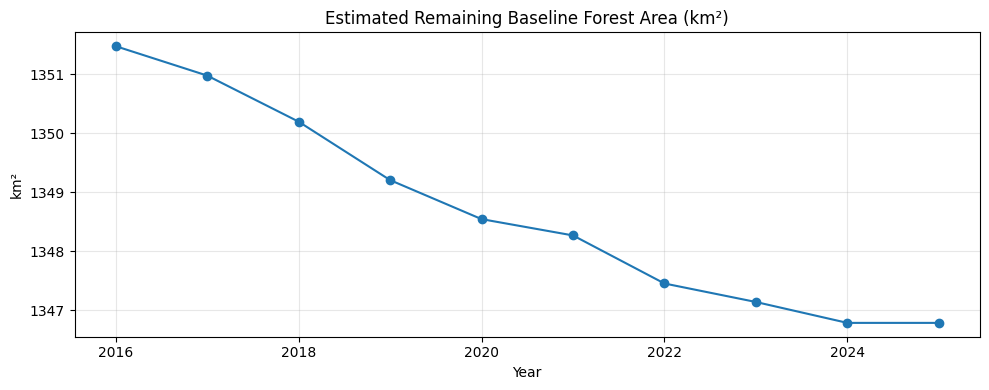

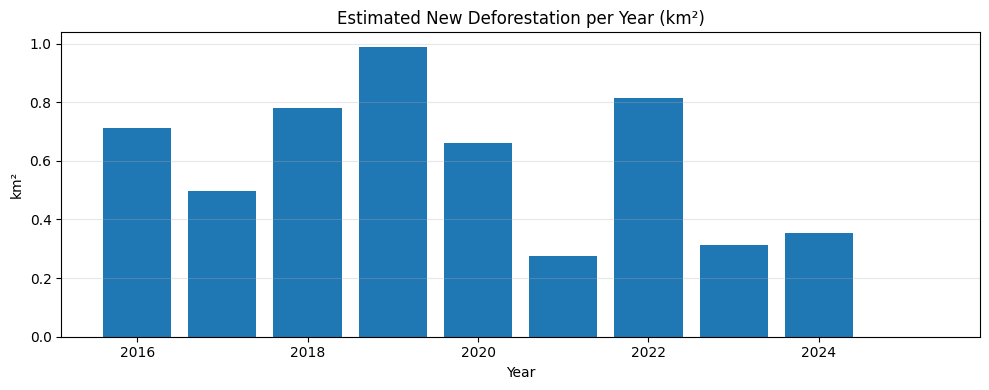

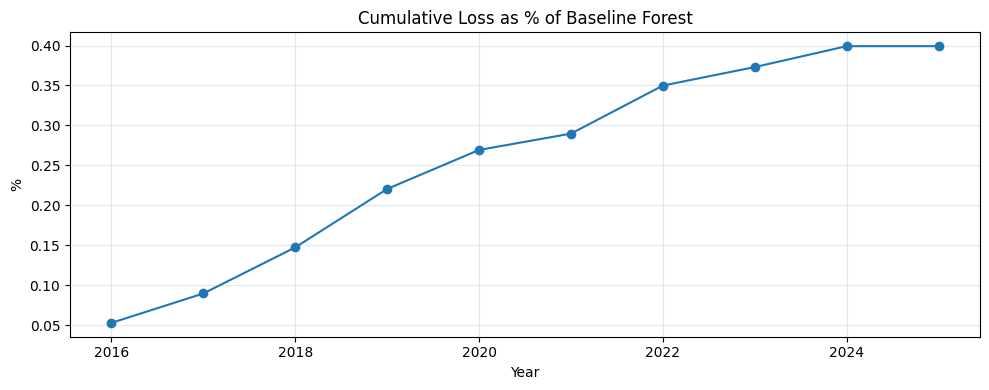

Saved figures under: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\figures


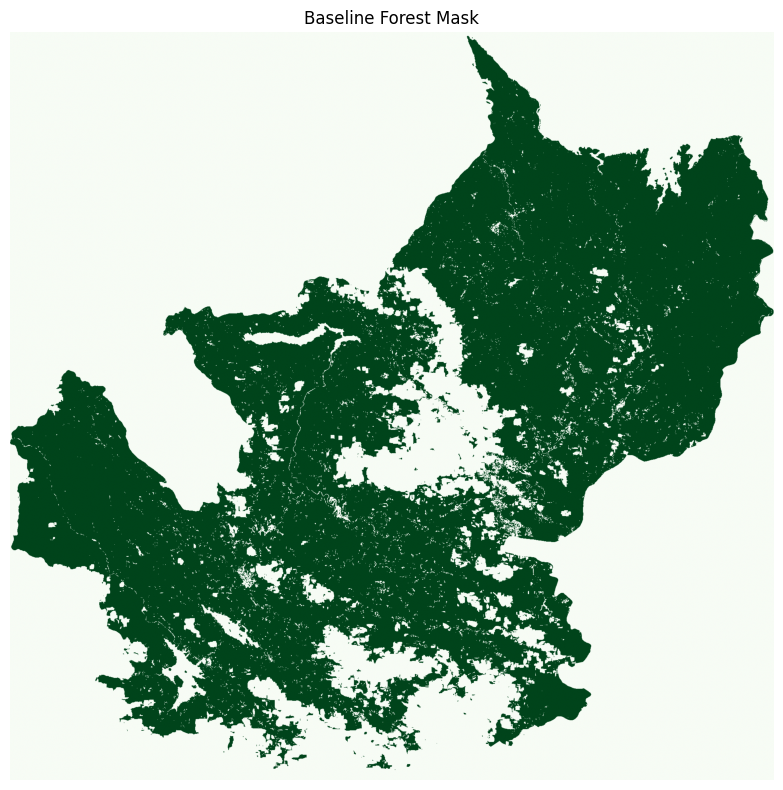

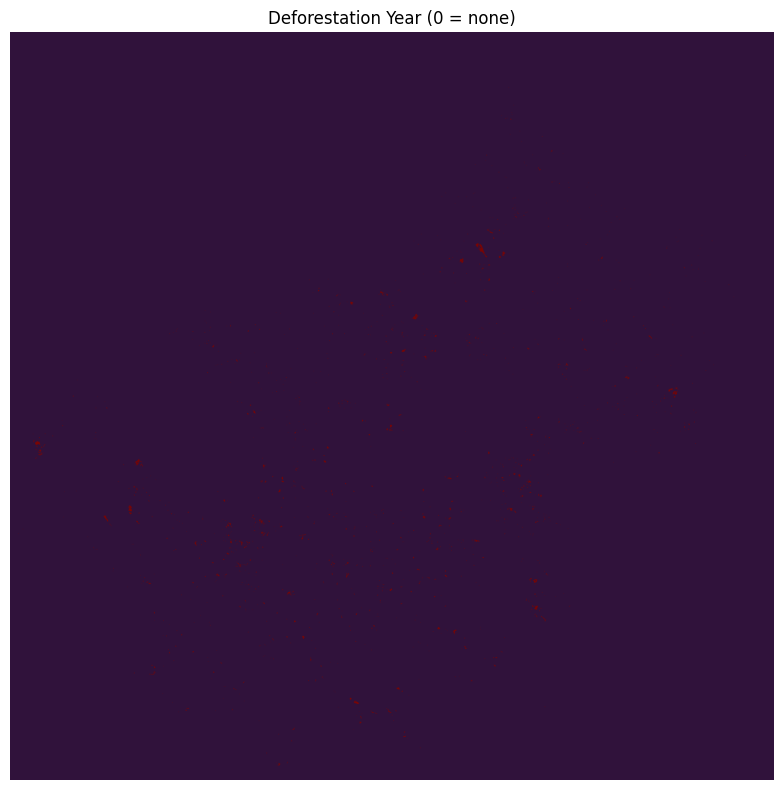

In [7]:
# 7) Statistics + detailed report plots
import matplotlib.pyplot as plt

# Pixel area: Landsat is 30m, but after reprojection grid could still be 30m.
# We'll compute from transform to be safer.
px_w = abs(ref_meta["transform"].a)
px_h = abs(ref_meta["transform"].e)
px_area_m2 = px_w * px_h
px_area_km2 = px_area_m2 / 1e6

baseline_forest_area_km2 = float(np.sum(baseline_forest == 1) * px_area_km2)

rows = []
for y in sorted(analysis_years):
    if y not in candidate_by_year and y not in composites:
        continue
    new_loss_km2 = float(np.sum(deforestation_year == y) * px_area_km2)
    rows.append({"year": y, "new_loss_km2": new_loss_km2})

stats = pd.DataFrame(rows)
stats["baseline_forest_area_km2"] = baseline_forest_area_km2
stats["cumulative_loss_km2"] = stats["new_loss_km2"].cumsum()
stats["percent_loss_of_baseline"] = np.where(
    baseline_forest_area_km2 > 0,
    100.0 * stats["cumulative_loss_km2"] / baseline_forest_area_km2,
    np.nan,
)

stats_path = out_dir / "Deforestation_Yearly_Stats.csv"
stats.to_csv(stats_path, index=False)
print("Saved:", stats_path)

# Plots
fig_dir = out_dir / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(10, 4))
plt.plot(stats["year"], baseline_forest_area_km2 - stats["cumulative_loss_km2"], marker="o")
plt.title("Estimated Remaining Baseline Forest Area (km²)")
plt.xlabel("Year")
plt.ylabel("km²")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(fig_dir / "remaining_forest_area.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(stats["year"], stats["new_loss_km2"]) 
plt.title("Estimated New Deforestation per Year (km²)")
plt.xlabel("Year")
plt.ylabel("km²")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(fig_dir / "annual_loss.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(stats["year"], stats["percent_loss_of_baseline"], marker="o")
plt.title("Cumulative Loss as % of Baseline Forest")
plt.xlabel("Year")
plt.ylabel("%")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(fig_dir / "cumulative_percent_loss.png", dpi=150)
plt.show()

print("Saved figures under:", fig_dir)

# Quick map views
plt.figure(figsize=(10, 8))
plt.imshow(baseline_forest, cmap="Greens")
plt.title("Baseline Forest Mask")
plt.axis("off")
plt.tight_layout()
plt.savefig(fig_dir / "baseline_forest_mask.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(deforestation_year, cmap="turbo")
plt.title("Deforestation Year (0 = none)")
plt.axis("off")
plt.tight_layout()
plt.savefig(fig_dir / "deforestation_year.png", dpi=150)
plt.show()


In [8]:
# 8) Run manifest (what was used/skipped + outputs)
manifest = {
    "run_started": datetime.now().isoformat(timespec="seconds"),
    "config": config,
    "n_scenes_found": int(len(red_files)),
    "n_scenes_usable": int(len(df_scenes)),
    "n_scenes_skipped_precheck": int(len(df_skipped)),
    "years_processed": years_all,
    "baseline_years_missing": missing_baseline,
    "outputs": {
        "baseline_ndvi": str(out_dir / "baseline_ndvi.tif"),
        "baseline_ndmi": str(out_dir / "baseline_ndmi.tif"),
        "baseline_forest_mask": str(out_dir / "baseline_forest_mask.tif"),
        "deforestation_year": str(out_dir / "deforestation_year.tif"),
        "deforestation_mask": str(out_dir / "deforestation_mask.tif"),
        "stats_csv": str(out_dir / "Deforestation_Yearly_Stats.csv"),
        "figures_dir": str(fig_dir),
    },
}

manifest_path = out_dir / "run_manifest.json"
manifest_path.write_text(json.dumps(manifest, indent=2), encoding="utf-8")
print("Saved:", manifest_path)

print("\nDefinition of done:")
for k, v in manifest["outputs"].items():
    print(f"- {k}: {v}")


Saved: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\run_manifest.json

Definition of done:
- baseline_ndvi: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\baseline_ndvi.tif
- baseline_ndmi: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\baseline_ndmi.tif
- baseline_forest_mask: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\baseline_forest_mask.tif
- deforestation_year: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\deforestation_year.tif
- deforestation_mask: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\deforestation_mask.tif
- stats_csv: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\Deforestation_Yearly_Stats.csv
- figures_dir: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\figures


## Reports (PDF exports)

This section exports three PDFs into a `reports/` folder under the run output directory (`out_dir`).

- `01_executive_summary.pdf`
- `02_yearly_stats_report.pdf`
- `03_map_atlas.pdf`


In [9]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


def _ensure_out_dir() -> Path:
    if "out_dir" in globals() and out_dir is not None:
        return Path(out_dir)

    # Fallback: infer from known project layout
    # (This assumes you are running from the notebook under PROJECT_ROOT/Code)
    if "PROJECT_ROOT" in globals() and PROJECT_ROOT is not None:
        candidate = Path(PROJECT_ROOT) / "NuwaraEliya"
        candidate.mkdir(parents=True, exist_ok=True)
        return candidate

    raise RuntimeError("Could not determine out_dir. Run the earlier cells first.")


def _postprocess_stats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Normalize/derive columns for reporting
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    for col in ["new_loss_km2", "cumulative_loss_km2", "percent_loss_of_baseline", "baseline_forest_area_km2", "remaining_forest_km2"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # If the source data only contains baseline + cumulative, derive remaining.
    if "remaining_forest_km2" not in df.columns:
        if {"baseline_forest_area_km2", "cumulative_loss_km2"}.issubset(df.columns):
            df["remaining_forest_km2"] = df["baseline_forest_area_km2"] - df["cumulative_loss_km2"]

    # If baseline missing but we have remaining + cumulative, derive baseline.
    if "baseline_forest_area_km2" not in df.columns:
        if {"remaining_forest_km2", "cumulative_loss_km2"}.issubset(df.columns):
            df["baseline_forest_area_km2"] = df["remaining_forest_km2"] + df["cumulative_loss_km2"]

    return df


def _load_stats(out_dir: Path) -> pd.DataFrame:
    if "stats" in globals() and isinstance(stats, pd.DataFrame) and not stats.empty:
        return _postprocess_stats(stats)

    stats_csv = out_dir / "Deforestation_Yearly_Stats.csv"
    if not stats_csv.exists():
        raise FileNotFoundError(f"Missing stats CSV: {stats_csv}")
    return _postprocess_stats(pd.read_csv(stats_csv))


def _load_raster_array(path: Path):
    import rasterio

    with rasterio.open(path) as src:
        arr = src.read(1)
        transform = src.transform
        crs = src.crs
        nodata = src.nodata
        h, w = arr.shape
        # extent in map coordinates for imshow
        left, top = transform * (0, 0)
        right, bottom = transform * (w, h)
        extent = (left, right, bottom, top)
    return arr, extent, crs, nodata


def _get_maps(out_dir: Path):
    # Prefer in-memory arrays if they exist; otherwise load from disk.
    baseline_path = out_dir / "baseline_forest_mask.tif"
    year_path = out_dir / "deforestation_year.tif"
    mask_path = out_dir / "deforestation_mask.tif"

    if "baseline_forest" in globals() and baseline_forest is not None:
        base_arr = np.asarray(baseline_forest)
        base_extent = globals().get("baseline_extent", None)
    else:
        base_arr, base_extent, _, _ = _load_raster_array(baseline_path)

    if "deforestation_year" in globals() and deforestation_year is not None:
        year_arr = np.asarray(deforestation_year)
        year_extent = globals().get("year_extent", None)
    else:
        year_arr, year_extent, _, _ = _load_raster_array(year_path)

    if "deforestation_mask" in globals() and deforestation_mask is not None:
        mask_arr = np.asarray(deforestation_mask)
        mask_extent = globals().get("loss_extent", None)
    else:
        mask_arr, mask_extent, _, _ = _load_raster_array(mask_path)

    # If extents weren't computed earlier, fall back to None (imshow pixel coords)
    return (
        base_arr,
        base_extent,
        year_arr,
        year_extent,
        mask_arr,
        mask_extent,
    )


def _plot_yearly_charts(stats_df: pd.DataFrame, *, title_prefix: str = ""):
    stats_df = stats_df.sort_values("year")

    fig, axes = plt.subplots(3, 1, figsize=(11, 8.5), constrained_layout=True)

    if {"year", "remaining_forest_km2"}.issubset(stats_df.columns):
        axes[0].plot(stats_df["year"], stats_df["remaining_forest_km2"], marker="o")
        axes[0].set_title(f"{title_prefix}Estimated Remaining Baseline Forest Area (km²)".strip())
        axes[0].set_xlabel("Year")
        axes[0].set_ylabel("km²")
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].axis("off")
        axes[0].text(0.01, 0.5, "Missing columns for remaining forest plot.", fontsize=11)

    if {"year", "new_loss_km2"}.issubset(stats_df.columns):
        axes[1].bar(stats_df["year"], stats_df["new_loss_km2"]) 
        axes[1].set_title(f"{title_prefix}Estimated New Deforestation per Year (km²)".strip())
        axes[1].set_xlabel("Year")
        axes[1].set_ylabel("km²")
        axes[1].grid(True, axis="y", alpha=0.3)
    else:
        axes[1].axis("off")
        axes[1].text(0.01, 0.5, "Missing columns for annual loss plot.", fontsize=11)

    if {"year", "percent_loss_of_baseline"}.issubset(stats_df.columns):
        axes[2].plot(stats_df["year"], stats_df["percent_loss_of_baseline"], marker="o")
        axes[2].set_title(f"{title_prefix}Cumulative Loss as % of Baseline Forest".strip())
        axes[2].set_xlabel("Year")
        axes[2].set_ylabel("%")
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].axis("off")
        axes[2].text(0.01, 0.5, "Missing columns for percent-loss plot.", fontsize=11)

    return fig


def _plot_stats_table(stats_df: pd.DataFrame):
    stats_df = stats_df.sort_values("year")

    # Keep table narrow and readable
    cols = [c for c in [
        "year",
        "new_loss_km2",
        "remaining_forest_km2",
        "cumulative_loss_km2",
        "percent_loss_of_baseline",
    ] if c in stats_df.columns]

    view = stats_df[cols].copy()
    for c in view.columns:
        if c != "year":
            view[c] = view[c].astype(float).round(4)

    fig, ax = plt.subplots(figsize=(11, 8.5))
    ax.axis("off")
    ax.set_title("Yearly Deforestation Statistics", pad=12)

    table = ax.table(
        cellText=view.values,
        colLabels=view.columns,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.25)

    return fig


def _plot_map_page(arr: np.ndarray, *, title: str, cmap: str, extent=None, add_colorbar: bool = True):
    fig, ax = plt.subplots(figsize=(11, 8.5))
    im = ax.imshow(arr, cmap=cmap, extent=extent)
    ax.set_title(title)
    ax.axis("off")
    if add_colorbar:
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    return fig


def _plot_year_map(year_arr: np.ndarray, *, extent=None):
    fig, ax = plt.subplots(figsize=(11, 8.5))
    im = ax.imshow(year_arr, cmap="turbo", extent=extent)
    ax.set_title("Deforestation Year (0 = none)")
    ax.axis("off")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    return fig


# --- Generate 3 PDF reports ---
out_dir = _ensure_out_dir()
reports_dir = out_dir / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

stats_df = _load_stats(out_dir)

# 1) Executive summary (1 page)
exec_pdf = reports_dir / "01_executive_summary.pdf"
with PdfPages(exec_pdf) as pdf:
    stats_sorted = stats_df.sort_values("year")
    years = stats_sorted["year"].dropna().astype(int).to_list() if "year" in stats_sorted.columns else []

    baseline_km2 = (
        float(stats_sorted["baseline_forest_area_km2"].iloc[0])
        if "baseline_forest_area_km2" in stats_sorted.columns and len(stats_sorted)
        else float("nan")
    )
    latest_remaining_km2 = (
        float(stats_sorted["remaining_forest_km2"].iloc[-1])
        if "remaining_forest_km2" in stats_sorted.columns and len(stats_sorted)
        else float("nan")
    )
    total_loss_km2 = (
        float(stats_sorted["cumulative_loss_km2"].iloc[-1])
        if "cumulative_loss_km2" in stats_sorted.columns and len(stats_sorted)
        else float("nan")
    )
    total_loss_pct = (
        float(stats_sorted["percent_loss_of_baseline"].iloc[-1])
        if "percent_loss_of_baseline" in stats_sorted.columns and len(stats_sorted)
        else float("nan")
    )

    worst_year = None
    worst_year_loss = float("nan")
    if {"new_loss_km2", "year"}.issubset(stats_sorted.columns) and len(stats_sorted):
        idx = stats_sorted["new_loss_km2"].astype(float).idxmax()
        worst_year = int(stats_sorted.loc[idx, "year"])
        worst_year_loss = float(stats_sorted.loc[idx, "new_loss_km2"])

    fig = plt.figure(figsize=(11, 8.5))
    fig.suptitle("Deforestation Executive Summary", fontsize=16, y=0.98)

    ax_text = fig.add_axes([0.06, 0.66, 0.88, 0.26])
    ax_text.axis("off")

    period = f"{min(years)}–{max(years)}" if years else "(unknown period)"
    lines = [
        f"Period: {period}",
        "",
        f"Baseline forest area: {baseline_km2:,.3f} km²",
        f"Remaining forest (latest): {latest_remaining_km2:,.3f} km²",
        f"Cumulative loss: {total_loss_km2:,.3f} km²",
        f"Cumulative loss: {total_loss_pct:,.3f}% of baseline",
    ]
    if worst_year is not None:
        lines.append(f"Highest annual loss: {worst_year} ({worst_year_loss:,.3f} km²)")

    ax_text.text(0, 1, "\n".join(lines), va="top", ha="left", fontsize=11)

    # # Small charts
    # ax1 = fig.add_axes([0.07, 0.44, 0.86, 0.18])
    # ax2 = fig.add_axes([0.07, 0.24, 0.86, 0.18])
    # ax3 = fig.add_axes([0.07, 0.04, 0.86, 0.18])

    # if {"year", "remaining_forest_km2"}.issubset(stats_sorted.columns):
    #     ax1.plot(stats_sorted["year"], stats_sorted["remaining_forest_km2"], marker="o")
    #     ax1.set_title("Remaining baseline forest (km²)", fontsize=10)
    #     ax1.grid(True, alpha=0.3)

    # if {"year", "new_loss_km2"}.issubset(stats_sorted.columns):
    #     ax2.bar(stats_sorted["year"], stats_sorted["new_loss_km2"])
    #     ax2.set_title("New deforestation per year (km²)", fontsize=10)
    #     ax2.grid(True, axis="y", alpha=0.3)

    # if {"year", "percent_loss_of_baseline"}.issubset(stats_sorted.columns):
    #     ax3.plot(stats_sorted["year"], stats_sorted["percent_loss_of_baseline"], marker="o")
    #     ax3.set_title("Cumulative loss (% of baseline)", fontsize=10)
    #     ax3.grid(True, alpha=0.3)

    # for ax in (ax1, ax2, ax3):
    #     ax.set_xlabel("Year")

    pdf.savefig(fig)
    plt.close(fig)

# 2) Yearly stats report (charts + table)
stats_pdf = reports_dir / "02_yearly_stats_report.pdf"
with PdfPages(stats_pdf) as pdf:
    fig_charts = _plot_yearly_charts(stats_df)
    pdf.savefig(fig_charts)
    plt.close(fig_charts)

    fig_table = _plot_stats_table(stats_df)
    pdf.savefig(fig_table)
    plt.close(fig_table)

# 3) Map atlas (baseline, year-of-loss, loss mask)
map_pdf = reports_dir / "03_map_atlas.pdf"
base_arr, base_extent, year_arr, year_extent, mask_arr, mask_extent = _get_maps(out_dir)

with PdfPages(map_pdf) as pdf:
    fig1 = _plot_map_page(base_arr, title="Baseline Forest Mask", cmap="Greens", extent=base_extent, add_colorbar=False)
    pdf.savefig(fig1)
    plt.close(fig1)

    fig2 = _plot_year_map(year_arr, extent=year_extent)
    pdf.savefig(fig2)
    plt.close(fig2)

    fig3 = _plot_map_page(mask_arr, title="Deforestation Mask (1 = loss)", cmap="Reds", extent=mask_extent, add_colorbar=False)
    pdf.savefig(fig3)
    plt.close(fig3)

print("Saved reports to:", reports_dir)
print("-", exec_pdf)
print("-", stats_pdf)
print("-", map_pdf)


Saved reports to: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\reports
- C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\reports\01_executive_summary.pdf
- C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\reports\02_yearly_stats_report.pdf
- C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\reports\03_map_atlas.pdf


## Nuwara Eliya — Deforestation prediction (2025–2030)

This section builds a forecast model for **Nuwara Eliya** using `Deforestation_Yearly_Stats.csv`.

- Uses years **2016–2024** for training/evaluation
- Tries multiple small-sample models and evaluates them with walk-forward validation
- Produces **2025–2030** predictions for `new_loss_km2` and derived `cumulative_loss_km2` / `percent_loss_of_baseline`


In [2]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd


def _resolve_nuwara_eliya_csv() -> Path:
    """Find Nuwara Eliya stats CSV regardless of notebook working directory."""
    candidates = [
        Path.cwd() / "NuwaraEliya" / "Deforestation_Yearly_Stats.csv",
        Path.cwd() / ".." / "NuwaraEliya" / "Deforestation_Yearly_Stats.csv",
        Path.cwd() / ".." / ".." / "NuwaraEliya" / "Deforestation_Yearly_Stats.csv",
    ]
    for p in candidates:
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(
        "Could not locate NuwaraEliya/Deforestation_Yearly_Stats.csv relative to the notebook. "
        f"Tried: {', '.join(str(p) for p in candidates)}"
    )


csv_path = _resolve_nuwara_eliya_csv()
print("Using:", csv_path)

df_raw = pd.read_csv(csv_path)
df_raw["year"] = df_raw["year"].astype(int)

# Ignore the 2025 row in the provided file (per request)
df = df_raw[df_raw["year"] <= 2024].copy()
df = df.sort_values("year").reset_index(drop=True)

# Basic sanity
assert df["year"].is_monotonic_increasing
assert df["year"].nunique() == len(df)

baseline_area = float(df["baseline_forest_area_km2"].iloc[0])
last_known_cum = float(df_raw.loc[df_raw["year"] == 2024, "cumulative_loss_km2"].iloc[0])

print(df[["year", "new_loss_km2", "cumulative_loss_km2"]].to_string(index=False))
print("baseline_forest_area_km2:", baseline_area)
print("last_known_cumulative_loss_km2 (2024):", last_known_cum)

Using: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\Deforestation_Yearly_Stats.csv
 year  new_loss_km2  cumulative_loss_km2
 2016        0.7137               0.7137
 2017        0.4977               1.2114
 2018        0.7803               1.9917
 2019        0.9891               2.9808
 2020        0.6606               3.6414
 2021        0.2763               3.9177
 2022        0.8136               4.7313
 2023        0.3132               5.0445
 2024        0.3537               5.3982
baseline_forest_area_km2: 1352.1879
last_known_cumulative_loss_km2 (2024): 5.3982


In [3]:
from __future__ import annotations

from math import sqrt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA


@dataclass(frozen=True)
class ModelSpec:
    name: str
    predict_one_step: Callable[[np.ndarray, np.ndarray, int], float]
    fit_forecast: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]


def _clip_nonneg(x: np.ndarray | float) -> np.ndarray | float:
    return np.maximum(x, 0.0)


def walk_forward_eval(
    years: np.ndarray,
    y: np.ndarray,
    model: ModelSpec,
    min_train: int = 3,
) -> Dict[str, float]:
    """Walk-forward (rolling origin) one-step evaluation."""
    y_true: List[float] = []
    y_pred: List[float] = []

    n = len(y)
    for t in range(min_train, n):
        train_years = years[:t]
        train_y = y[:t]
        test_year = int(years[t])
        test_y = float(y[t])

        try:
            pred = float(model.predict_one_step(train_years, train_y, test_year))
            pred = float(_clip_nonneg(pred))
        except Exception:
            # If a model fails on a small fold, skip that fold
            continue

        y_true.append(test_y)
        y_pred.append(pred)

    if len(y_true) == 0:
        return {"folds": 0, "mae": np.nan, "rmse": np.nan, "mape": np.nan}

    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)

    mae = float(np.mean(np.abs(y_pred_arr - y_true_arr)))
    rmse = float(sqrt(np.mean((y_pred_arr - y_true_arr) ** 2)))
    mape = float(np.mean(np.abs((y_pred_arr - y_true_arr) / y_true_arr)) * 100.0)

    return {"folds": len(y_true), "mae": mae, "rmse": rmse, "mape": mape}


def _make_lin_reg() -> Pipeline:
    return Pipeline([
        ("lr", LinearRegression()),
    ])


def _make_ridge(alpha: float = 1.0) -> Pipeline:
    return Pipeline([
        ("ridge", Ridge(alpha=alpha)),
    ])


def _make_poly(degree: int) -> Pipeline:
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lr", LinearRegression()),
    ])


def _predict_sklearn_one_step(pipe_factory: Callable[[], Pipeline], train_years: np.ndarray, train_y: np.ndarray, next_year: int) -> float:
    model = pipe_factory()
    X = train_years.reshape(-1, 1)
    model.fit(X, train_y)
    return float(model.predict(np.array([[next_year]], dtype=float))[0])


def _forecast_sklearn(pipe_factory: Callable[[], Pipeline], years: np.ndarray, y: np.ndarray, years_future: np.ndarray) -> np.ndarray:
    model = pipe_factory()
    model.fit(years.reshape(-1, 1), y)
    return _clip_nonneg(model.predict(years_future.reshape(-1, 1)).astype(float))


def _predict_naive(train_years: np.ndarray, train_y: np.ndarray, next_year: int) -> float:
    return float(train_y[-1])


def _forecast_naive(years: np.ndarray, y: np.ndarray, years_future: np.ndarray) -> np.ndarray:
    return np.full(shape=len(years_future), fill_value=float(y[-1]), dtype=float)


def _predict_drift(train_years: np.ndarray, train_y: np.ndarray, next_year: int) -> float:
    dy = float(train_y[-1] - train_y[0])
    dt = float(train_years[-1] - train_years[0])
    slope = dy / dt if dt != 0 else 0.0
    return float(train_y[-1] + slope * (next_year - int(train_years[-1])))


def _forecast_drift(years: np.ndarray, y: np.ndarray, years_future: np.ndarray) -> np.ndarray:
    dy = float(y[-1] - y[0])
    dt = float(years[-1] - years[0])
    slope = dy / dt if dt != 0 else 0.0
    return _clip_nonneg(y[-1] + slope * (years_future - years[-1]))


def _predict_holt(train_years: np.ndarray, train_y: np.ndarray, next_year: int) -> float:
    fit = Holt(train_y, exponential=False, damped_trend=False).fit(optimized=True)
    return float(fit.forecast(1)[0])


def _forecast_holt(years: np.ndarray, y: np.ndarray, years_future: np.ndarray) -> np.ndarray:
    steps = len(years_future)
    fit = Holt(y, exponential=False, damped_trend=False).fit(optimized=True)
    return _clip_nonneg(np.asarray(fit.forecast(steps), dtype=float))


def _make_arima_order(order: Tuple[int, int, int]) -> ModelSpec:
    p, d, q = order
    name = f"ARIMA({p},{d},{q})"

    def _predict_one(train_years: np.ndarray, train_y: np.ndarray, next_year: int) -> float:
        fit = ARIMA(train_y, order=order).fit()
        return float(fit.forecast(1)[0])

    def _forecast(years: np.ndarray, y: np.ndarray, years_future: np.ndarray) -> np.ndarray:
        fit = ARIMA(y, order=order).fit()
        return _clip_nonneg(np.asarray(fit.forecast(len(years_future)), dtype=float))

    return ModelSpec(name=name, predict_one_step=_predict_one, fit_forecast=_forecast)


# Build candidate model list (reasonable for very small yearly dataset)
models: List[ModelSpec] = [
    ModelSpec(
        name="Naive (last value)",
        predict_one_step=_predict_naive,
        fit_forecast=_forecast_naive,
    ),
    ModelSpec(
        name="Drift (straight-line from first to last)",
        predict_one_step=_predict_drift,
        fit_forecast=_forecast_drift,
    ),
    ModelSpec(
        name="Linear Regression (year → loss)",
        predict_one_step=lambda yrs, yy, ny: _predict_sklearn_one_step(_make_lin_reg, yrs, yy, ny),
        fit_forecast=lambda yrs, yy, fut: _forecast_sklearn(_make_lin_reg, yrs, yy, fut),
    ),
    ModelSpec(
        name="Ridge Regression (year → loss)",
        predict_one_step=lambda yrs, yy, ny: _predict_sklearn_one_step(lambda: _make_ridge(alpha=1.0), yrs, yy, ny),
        fit_forecast=lambda yrs, yy, fut: _forecast_sklearn(lambda: _make_ridge(alpha=1.0), yrs, yy, fut),
    ),
    ModelSpec(
        name="Polynomial Regression deg=2",
        predict_one_step=lambda yrs, yy, ny: _predict_sklearn_one_step(lambda: _make_poly(2), yrs, yy, ny),
        fit_forecast=lambda yrs, yy, fut: _forecast_sklearn(lambda: _make_poly(2), yrs, yy, fut),
    ),
    ModelSpec(
        name="Polynomial Regression deg=3",
        predict_one_step=lambda yrs, yy, ny: _predict_sklearn_one_step(lambda: _make_poly(3), yrs, yy, ny),
        fit_forecast=lambda yrs, yy, fut: _forecast_sklearn(lambda: _make_poly(3), yrs, yy, fut),
    ),
    ModelSpec(
        name="Holt Linear Trend",
        predict_one_step=_predict_holt,
        fit_forecast=_forecast_holt,
    ),
]

# Small ARIMA grid (keep tiny because data is tiny)
for order in [(0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 0, 0), (0, 0, 1), (1, 0, 1)]:
    models.append(_make_arima_order(order))

print("Candidate models:")
for m in models:
    print(" -", m.name)

Candidate models:
 - Naive (last value)
 - Drift (straight-line from first to last)
 - Linear Regression (year → loss)
 - Ridge Regression (year → loss)
 - Polynomial Regression deg=2
 - Polynomial Regression deg=3
 - Holt Linear Trend
 - ARIMA(0,1,0)
 - ARIMA(1,1,0)
 - ARIMA(0,1,1)
 - ARIMA(1,0,0)
 - ARIMA(0,0,1)
 - ARIMA(1,0,1)


Walk-forward validation results (lower is better):


,model,folds,mae,rmse,mape
0,Ridge Regression (year → loss),6,0.3163,0.3415,75.33
1,Linear Regression (year → loss),6,0.3226,0.3498,76.68
2,"ARIMA(1,0,0)",6,0.3316,0.3606,78.69
3,Naive (last value),6,0.3333,0.3741,74.53
4,"ARIMA(0,1,0)",6,0.3333,0.3741,74.53
5,Holt Linear Trend,6,0.3562,0.4169,68.29
6,Drift (straight-line from first to last),6,0.3677,0.4108,80.86
7,"ARIMA(1,0,1)",6,0.3935,0.4106,89.47
8,"ARIMA(0,0,1)",6,0.3999,0.4153,94.50
9,"ARIMA(0,1,1)",6,0.3999,0.4205,86.73



Best model by walk-forward MAE: Ridge Regression (year → loss)

Forecast (2025–2030):


,year,pred_new_loss_km2,pred_cumulative_loss_km2,pred_percent_loss_of_baseline
0,2025,0.3834,5.7816,0.004276
1,2026,0.3402,6.1218,0.004527
2,2027,0.2969,6.4187,0.004747
3,2028,0.2536,6.6723,0.004934
4,2029,0.2103,6.8826,0.005090
5,2030,0.1671,7.0497,0.005214


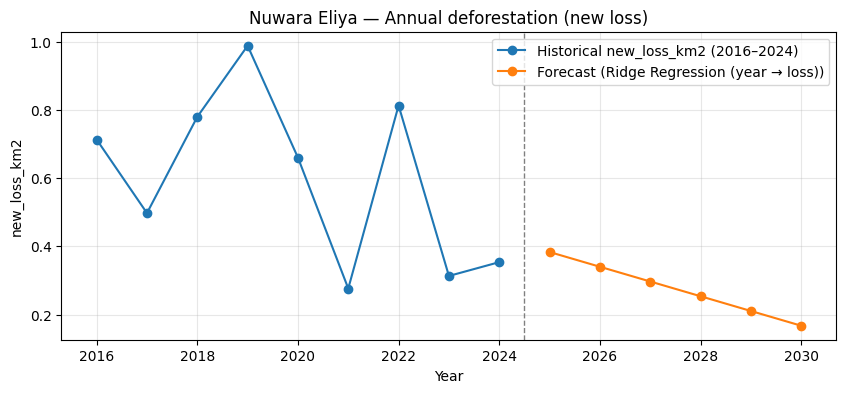

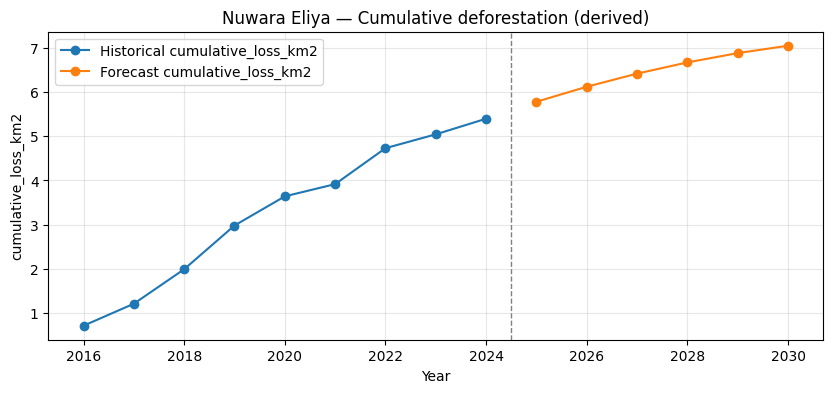

In [4]:
import warnings

import matplotlib.pyplot as plt

# Keep statsmodels ARIMA warnings from overwhelming notebook output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Prepare series
years = df["year"].to_numpy(dtype=int)
y = df["new_loss_km2"].to_numpy(dtype=float)

# Evaluate
rows = []
for m in models:
    metrics = walk_forward_eval(years, y, m, min_train=3)
    rows.append({"model": m.name, **metrics})

eval_df = pd.DataFrame(rows)
# Sort by MAE (primary), then RMSE
ranked = eval_df.sort_values(["mae", "rmse"], ascending=True).reset_index(drop=True)

print("Walk-forward validation results (lower is better):")
display(ranked.style.format({"mae": "{:.4f}", "rmse": "{:.4f}", "mape": "{:.2f}", "folds": "{:.0f}"}))

best_model_name = ranked.loc[0, "model"]
best_model = next(m for m in models if m.name == best_model_name)
print("\nBest model by walk-forward MAE:", best_model.name)

# Forecast 2025-2030
future_years = np.arange(2025, 2031, dtype=int)
future_pred = best_model.fit_forecast(years.astype(float), y.astype(float), future_years.astype(float))
future_pred = np.asarray(future_pred, dtype=float)

forecast = pd.DataFrame({
    "year": future_years,
    "pred_new_loss_km2": future_pred,
})

# Derived cumulative + percent loss (matching file convention: fraction of baseline, not 0-100 percent)
forecast["pred_cumulative_loss_km2"] = last_known_cum + forecast["pred_new_loss_km2"].cumsum()
forecast["pred_percent_loss_of_baseline"] = forecast["pred_cumulative_loss_km2"] / baseline_area

print("\nForecast (2025–2030):")
display(forecast.style.format({
    "pred_new_loss_km2": "{:.4f}",
    "pred_cumulative_loss_km2": "{:.4f}",
    "pred_percent_loss_of_baseline": "{:.6f}",
}))

# Plot: historical + forecast
plt.figure(figsize=(10, 4))
plt.plot(df["year"], df["new_loss_km2"], marker="o", label="Historical new_loss_km2 (2016–2024)")
plt.plot(forecast["year"], forecast["pred_new_loss_km2"], marker="o", label=f"Forecast ({best_model.name})")
plt.axvline(2024.5, color="gray", linestyle="--", linewidth=1)
plt.title("Nuwara Eliya — Annual deforestation (new loss)")
plt.xlabel("Year")
plt.ylabel("new_loss_km2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df["year"], df["cumulative_loss_km2"], marker="o", label="Historical cumulative_loss_km2")
plt.plot(forecast["year"], forecast["pred_cumulative_loss_km2"], marker="o", label="Forecast cumulative_loss_km2")
plt.axvline(2024.5, color="gray", linestyle="--", linewidth=1)
plt.title("Nuwara Eliya — Cumulative deforestation (derived)")
plt.xlabel("Year")
plt.ylabel("cumulative_loss_km2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [5]:
# Export forecast to CSV (next to the source stats file)
out_path = csv_path.parent / "Deforestation_Forecast_2025_2030.csv"
forecast.to_csv(out_path, index=False)
print("Saved forecast CSV to:", out_path)

Saved forecast CSV to: C:\Users\User\Desktop\Deforestation\Deforestation\NuwaraEliya\Deforestation_Forecast_2025_2030.csv
